# Introduction

You work for the OilyGiant mining company. Your task is to find the best place for a new well.
Steps to choose the location:
- Collect the oil well parameters in the selected region: oil quality and volume of reserves;
- Build a model for predicting the volume of reserves in the new wells;
- Pick the oil wells with the highest estimated values;
- Pick the region with the highest total profit for the selected oil wells.
You have data on oil samples from three regions. 

Parameters of each oil well in the region are already known. Build a model that will help to pick the region with the highest profit margin. 

Analyze potential profit and risks using the Bootstrapping technique.

# Download and preparing the data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LogisticRegressionCV
from sklearn.utils import shuffle
from scipy import stats as st

In [29]:
geo0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

geo1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

geo2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [30]:
def process_data(geo):
    print(geo.head())
    print(geo.isna().sum())
    print(geo.info())
    print(geo.describe())
    
process_data(geo0)
process_data(geo1)
process_data(geo2)

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.5


The datasets are in great form
- There are no null values in the datasets.
- The datatypes work for the columns.


# Train and test the model for each region


In [31]:
def split(geo):
    features = geo.drop(columns=['product', 'id'])
    target =  geo["product"]
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)
    print('Length of split dataset:')
    print(len(features_train))
    print(len(target_train))
    print(len(features_test))
    print(len(target_test))
    return features_train, features_test, target_train, target_test

features_train0, features_test0, target_train0, target_test0 = split(geo0)
features_train1, features_test1, target_train1, target_test1 = split(geo1)
features_train2, features_test2, target_train2, target_test2 = split(geo2)


Length of split dataset:
75000
75000
25000
25000
Length of split dataset:
75000
75000
25000
25000
Length of split dataset:
75000
75000
25000
25000


In [32]:
def linearreg(features_train, features_test, target_train, target_test):
    to_normalize = ['f0','f1','f2']
    scaler = StandardScaler()
    scaler.fit(features_train[to_normalize])
    features_train.loc[:,to_normalize] = scaler.transform(features_train[to_normalize])
    features_test.loc[:,to_normalize] = scaler.transform(features_test[to_normalize])
    lreg = LinearRegression().fit(features_train,target_train)
    predicted_value = lreg.predict(features_test)
    print('R2', lreg.score(features_test, target_test))
    print('RMSE:', np.sqrt(mean_squared_error(target_test, predicted_value)))
    print('Average predicted volume of reserve:',predicted_value.mean() )
    return predicted_value

predicted_value0 = linearreg(features_train0, features_test0, target_train0, target_test0)
predicted_value1 = linearreg(features_train1, features_test1, target_train1, target_test1)
predicted_value2 = linearreg(features_train2, features_test2, target_train2, target_test2)
    

R2 0.27994321524487786
RMSE: 37.5794217150813
Average predicted volume of reserve: 92.59256778438035
R2 0.9996233978805127
RMSE: 0.893099286775617
Average predicted volume of reserve: 68.728546895446
R2 0.20524758386040443
RMSE: 40.02970873393434
Average predicted volume of reserve: 94.96504596800489


The average predicted volume of reserve(s) for the first region is 92.59, for the second region it's 68.73 and for the third region it's 94.97.
This shows that the first and third regions should be favored as opposed to the second.

# Prepare for profit calculation


We must adhere to the following conditions:

- Only linear regression is suitable for model training (the rest are not sufficiently predictable).

- When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.

- The budget for development of 200 oil wells is 100 USD million.

- One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).

- After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

In [33]:
points = 500
bestpoints = 200
wells = 200
budget = 100000000
price = 4.5
unit = 1000
risk = 0.025
print('The volume of reserves sufficient for developing a new well without losses is:', budget/bestpoints/(price*unit))

The volume of reserves sufficient for developing a new well without losses is: 111.11111111111111


In [34]:
def profit(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:bestpoints]
    return (selected.sum()* (price*unit)) - budget

print('$',profit(target_test0, predicted_values0))
print('$',profit(target_test1, predicted_values1))
print('$',profit(target_test2, predicted_values2))


$ 33208260.43139851
$ 24150866.966815114
$ 27103499.635998324


The function above calculates the profit from the best 200 wells based on model predictions.



The first region  gives us a predicted profit of USD 33,208,260.43. This will be the best place to develop wells. 

 # Pick the wells with the highest values of prediction

In [44]:
def highest_wells(target, probabilities,number):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:bestpoints]
    return selected.head(number)

print(highest_wells(target_test0, predicted_values0, 5))
print(highest_wells(target_test1, predicted_values1, 5))
print(highest_wells(target_test2, predicted_values2, 5))


9317     162.810993
219      153.639837
10015    162.153488
11584     96.893581
23388    178.879516
Name: product, dtype: float64
20430    137.945408
7777     137.945408
8755     137.945408
1178     137.945408
4285     137.945408
Name: product, dtype: float64
22636    175.103291
24690    131.627481
7811     141.160070
1581     159.676082
6751     142.135203
Name: product, dtype: float64


Wells with the highest values for each region are printed above. 

# Calculate risks and profit for each region

Wells that make a profit: 931
Proportion of wells that make a profit: 0.931


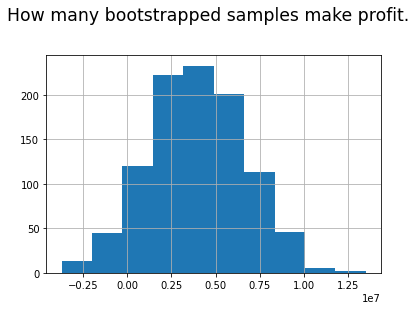

In [45]:
def bs_profit(target, probabilities):
    profits = []
    target = pd.Series(target).reset_index(drop=True)
    state = np.random.RandomState(12345)
    for i in range(1000):
        target_subsample = target.sample(n=points, replace=True, random_state = state)
        probs_subsample = probabilities[target_subsample.index]
        profits.append(profit(target_subsample, probs_subsample))

    profits = pd.Series(profits)
    print('Wells that make a profit:',profits.gt(0).sum())
    print('Proportion of wells that make a profit:', profits.gt(0).sum()/len(profits))
    
    profits.hist()
    plt.suptitle('How many bootstrapped samples make profit.', x=0.5, y=1.05, ha='center', fontsize='xx-large')

    return profits

bs0 = bs_profit(target_test0, predicted_values0)


Wells that make a profit: 985
Proportion of wells that make a profit: 0.985


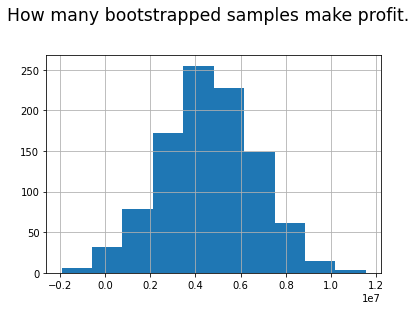

In [46]:
bs1 = bs_profit(target_test1, predicted_values1)


Wells that make a profit: 924
Proportion of wells that make a profit: 0.924


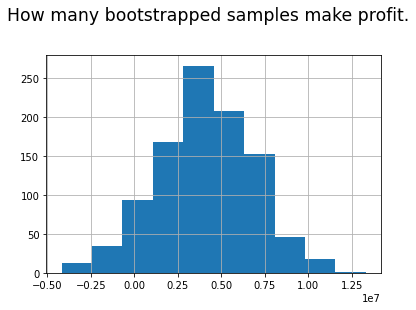

In [47]:
bs2 = bs_profit(target_test2, predicted_values2)


The histograms above show us that it's unlikely for the investment to end in an loss. The bootstrapping with 1000 iterations gives us good confidence since the resulting histogram(s) follows normal distribution.

In [50]:
def conf_int(profits):
    ci = st.t.interval(0.95, len(profits)-1, profits.mean(), profits.sem())
    risk = len(profits[profits < 0]) / len(profits)
    print('The average profit for this region is: ',profits.mean())
    print('The 95% confidence interval is:', ci[0], ',' ,ci[1] )
    print('The risk of losses is', risk)
    
def bs_conf_int(profits):

    
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    print('Confidence interval from the quantile method:', lower, ',',upper)
    
conf_int(bs0)
bs_conf_int(bs0)

conf_int(bs1)
bs_conf_int(bs1)

conf_int(bs2)
bs_conf_int(bs2)

The average profit for this region is:  3961649.8480237117
The 95% confidence interval is: 3796203.1514797257 , 4127096.5445676977
The risk of losses is 0.069
Confidence interval from the quantile method: -1112155.4589049604 , 9097669.41553423
The average profit for this region is:  4560451.057866608
The 95% confidence interval is: 4431472.486639005 , 4689429.62909421
The risk of losses is 0.015
Confidence interval from the quantile method: 338205.0939898458 , 8522894.538660347
The average profit for this region is:  4044038.665683568
The 95% confidence interval is: 3874457.974712804 , 4213619.356654332
The risk of losses is 0.076
Confidence interval from the quantile method: -1633504.1339559986 , 9503595.749237997


The results we arrived at from bootstrapping are different from Linear Regression. 

 #  Conclusion

The quality of the models was evaluated and we got satisfactory R-squared metrics for each region's model. We found that the volume of reserves sufficient for developing a new well without losses is: 111.11.

Bootstrapping gave us a different insight into the who the company should invest into.
We saw that all three of the regions have a great, profit prediction. The risk of loss is 0.015 for the second region. With this substantial difference from the first and third region we see where the company should dig their wells in.